# SCENIC+: Pipeline

# SCENIC+: Step-by-step multiome analysis

## 1. Set-up
As a starting point, we need fragment files for sc/snATAC-seq data and something that can be read into AnnData for sc/snRNA-seq data.

In [2]:
import os
import sys
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
_stderr = sys.stderr
null = open(os.devnull,'wb')

Either download or check that you have fragment files for your data. These are often in `tsv.gz` format.

In [3]:
!ls -lh /cellar/users/aklie/data/igvf/topic_grn_links/mouse_adrenal/encode/fragments

total 33K
drwxr-xr-x 3 aklie carter-users   1 Jan  5 10:03 ENCFF035SPT
drwxr-xr-x 3 aklie carter-users   1 Jan  5 10:03 ENCFF042ZJI
drwxr-xr-x 3 aklie carter-users   1 Jan  5 10:04 ENCFF101BLM
drwxr-xr-x 3 aklie carter-users   1 Jan  5 10:04 ENCFF119IVK
drwxr-xr-x 3 aklie carter-users   1 Jan  5 10:04 ENCFF176LJV
drwxr-xr-x 3 aklie carter-users   1 Jan  5 10:04 ENCFF187VMN
drwxr-xr-x 3 aklie carter-users   1 Jan  5 10:04 ENCFF622EUO
drwxr-xr-x 3 aklie carter-users   1 Jan  5 10:05 ENCFF683IBE
-rw-r--r-- 1 aklie carter-users 29K Jan  5 09:55 metadata.tsv


Either download or check that you have a file or set of files that can be read into a scanpy anndata object

In [4]:
!ls -lh /cellar/users/aklie/data/igvf/topic_grn_links/mouse_adrenal/preprocess/snrna/filtered.h5ad

-rw-r--r-- 1 aklie carter-users 801M Jan 13 09:46 /cellar/users/aklie/data/igvf/topic_grn_links/mouse_adrenal/preprocess/snrna/filtered.h5ad


## 2. scRNA-seq analysis

Set-up the directories for running a scRNA-seq analysis with scanpy. If you have already processed data you can skip this step. You will need a DataFrame with cell type labels as one of the columns to proceed.

In [5]:
work_dir = 'mouse_adrenal'

In [6]:
import scanpy as sc

# Set some figure parameters for nice display inside jupyternotebooks.
%matplotlib inline
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(5, 5), facecolor='white')

# Make a directory for to store the processed scRNA-seq data.
if not os.path.exists(os.path.join(work_dir, 'scRNA')):
    os.makedirs(os.path.join(work_dir, 'scRNA'))

For the ENCODE phase 4 mouse data, we have multiple cell type labels at our disposal.

In [7]:
adata = sc.read_h5ad(os.path.join(work_dir, 'data/adata.h5ad'))
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 79209 × 47721
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cellID', 'doublet_scores', 'doublets', 'library_accession', 'technology', 'species', 'tissue', 'sex', 'timepoint', 'rep', 'sample', 'depth1', 'depth2', 'experiment', 'experiment_batch', 'integration_batch', 'run_number', 'experiment_accession', 'file_accession', 'lower_nCount_RNA', 'upper_nCount_RNA', 'lower_nFeature_RNA', 'upper_doublet_scores', 'upper_percent.mt', 'percent.mt', 'percent.ribo', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.1.6', 'seurat_clusters', 'S.Score', 'G2M.Score', 'Phase', 'subtypes', 'celltypes', 'gen_celltype', 'Cortex_membership_score', 'Endothelial_membership_score', 'Adipocytes_membership_score', 'Myeloid_membership_score', 'Sox10._membership_score', 'Fibroblast_membership_score', 'Medulla_membership_score', 'Stromal_membership_score', 'Smooth_muscle_membership_score', 'Capsule_membership_score', 'Hepatocyte_membership_score', 'Myonuclei_membership_

## 3. scATAC-seq analysis

Set-up for running a scATAC-seq analysis with pycisTopic.

In [8]:
import pycisTopic

#make a directory for to store the processed scRNA-seq data.
if not os.path.exists(os.path.join(work_dir, 'scATAC')):
    os.makedirs(os.path.join(work_dir, 'scATAC'))
tmp_dir = '/cellar/users/aklie/tmp/'

You will need to create a dictionary with values as paths to fragment files and keys as sample names.

In [9]:
import glob as glob
import pandas as pd

# Load in the paths to your fragment files and turn them into a dictionary
frag_files = glob.glob("/cellar/users/aklie/data/igvf/topic_grn_links/mouse_adrenal/encode/fragments/*/*/*/*/*/*.tsv.gz")
fragments_dict = dict(zip([file.split("/")[-6] for file in frag_files], frag_files))

Read in or grab the metadata from any previous methods for annotations

In [10]:
# Grab the metadata from the single cell anndata 
cell_data = adata.obs
del(adata)

In [11]:
# For the mouse ENCODE 4 data, only a subset of the cells were from the 10x multiome kit
cell_data = cell_data[cell_data["technology"] == "10x"]
cell_data['celltype'] = cell_data['celltypes'].astype(str) # set data type of the celltype column to str, otherwise the export_pseudobulk function will complain.
cell_data["celltype"].value_counts(dropna=False)

/tmp/ipykernel_2087448/1951734722.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_data['celltype'] = cell_data['celltypes'].astype(str) # set data type of the celltype column to str, otherwise the export_pseudobulk function will complain.


Cortex             22227
Endothelial         4965
Medulla             3370
Stromal             1406
Macrophages          971
Adipocytes           872
Fibroblast           833
Sox10+               216
Smooth_muscle         63
Capsule               57
Hepatocyte            15
Skeletal_muscle        1
Name: celltype, dtype: int64

Next you should make sure that you have barcodes in your cell metadata that match the barcodes in your fragment files. This can be tricky, but you can use the following as examples

In [12]:
# Read in some extra metadata to match cells to samples and toconvert barcodes
snatac_meta = pd.read_csv("/cellar/users/aklie/data/igvf/topic_grn_links/mouse_adrenal/encode/enc4_mouse_snatac_metadata.tsv", sep="\t")
acc_mp = snatac_meta.set_index("rna_library_accession")["file_accession"]
cell_data["sample_id"] = cell_data["library_accession"].map(acc_mp).values
cell_data["sample_id"].value_counts(dropna=False)

/tmp/ipykernel_2087448/881422543.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_data["sample_id"] = cell_data["library_accession"].map(acc_mp).values


ENCFF683IBE    5270
ENCFF176LJV    5163
ENCFF035SPT    4584
ENCFF622EUO    4507
ENCFF101BLM    4324
ENCFF119IVK    3989
ENCFF042ZJI    3987
ENCFF187VMN    3172
Name: sample_id, dtype: int64

Map the RNA barcodes from the anndata to the ATAC barcodes present in the fragment file

In [13]:
# Map the RNA barcodes from the anndata to the ATAC barcodes present in the fragment file
rna_bcs = pd.read_csv("/cellar/users/aklie/data/igvf/topic_grn_links/mouse_adrenal/encode/gene_exp_737K-arc-v1.txt", header=None)[0].values # read in the set of external rna barcodes
atac_bcs = pd.read_csv("/cellar/users/aklie/data/igvf/topic_grn_links/mouse_adrenal/encode/atac_737K-arc-v1.txt", header=None)[0].values # Read in the set of external atac barcodes
bcs = pd.DataFrame(data={"rna_bcs": rna_bcs, "atac_bcs": atac_bcs}) # create a dataframe with both
COMPLEMENT_DNA = {"A": "T", "C": "G", "G": "C", "T": "A"} # the fragment files contain reverse complements of the atac bcs, need to get these
bcs["atac_bcs_rc"] = ["".join(COMPLEMENT_DNA.get(base, base) for base in reversed(bc)) for bc in bcs["atac_bcs"]]
bc_map = bcs.set_index("rna_bcs")["atac_bcs_rc"] # create a map for going from rna bcs to atac bcs in fragment files

In [14]:
# Map the rna bcs in the cell metadata to the fragment file atac barcodes
cell_data["rna_bc"] = [row[0] for row in cell_data["cellID"].str.split(".")] # grab the RNA barcodes from the anndata metadata
cell_data["atac_bc"] = cell_data["rna_bc"].map(bc_map) # map the
cell_data["atac_bc_sample"] = cell_data["atac_bc"] + "-" + cell_data["sample_id"]
cell_data["barcode"] = cell_data["atac_bc"]
cell_data = cell_data.set_index("atac_bc")

/tmp/ipykernel_2087448/492677571.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_data["rna_bc"] = [row[0] for row in cell_data["cellID"].str.split(".")] # grab the RNA barcodes from the anndata metadata
/tmp/ipykernel_2087448/492677571.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_data["atac_bc"] = cell_data["rna_bc"].map(bc_map) # map the
/tmp/ipykernel_2087448/492677571.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [ ]:
# Run a quick sanity check to make sure your barcodes match up
test_fragments = pd.read_csv(fragments_dict["ENCFF187VMN"], sep="\t", header=None)
test_cell_data = cell_data[cell_data["sample_id"] == "ENCFF187VMN"]
len(test_cell_data), test_cell_data["barcode"].isin(test_fragments[3]).sum()

We also need chromosome sizes in order to export to pseudobulk and to call peaks. Read these in. Make sure you choose the correct species for your data!

In [15]:
import pyranges as pr
import requests

# Stream directly into memory using pandas
target_url='https://hgdownload.cse.ucsc.edu/goldenpath/mm10/bigZips/mm10.chrom.sizes'
chromsizes=pd.read_csv(target_url, sep='\t', header=None)
chromsizes.columns=['Chromosome', 'End']
chromsizes['Start']=[0]*chromsizes.shape[0]
chromsizes=chromsizes.loc[:,['Chromosome', 'Start', 'End']]
chromsizes=pr.PyRanges(chromsizes)

The next big step is to generate bed and bw files using all the fragments within each cell type. pycisTopic has a decent function for this that's a little finicky. A couple things to make sure of:
- You have a "barcode" column with barcodes that match the barcodes in your fragment files
- You have a "sample_id" column that maps cells to the samples contained in your fragment file dictionary
- Your chromosomes in the chromsizes object you created match the chromsomes in your fragment files (make sure you have the right species)
- You have enough total memory to handle ray's parallelization (if you use it)

In [26]:
from pycisTopic.pseudobulk_peak_calling import export_pseudobulk

# Run without ray since these are big files
bw_paths, bed_paths = export_pseudobulk(
    input_data = cell_data,
    variable = 'celltype', # variable by which to generate pseubulk profiles, in this case we want pseudobulks per celltype
    sample_id_col = 'sample_id',
    chromsizes = chromsizes,
    bed_path = os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bed_files/'),  # specify where pseudobulk_bed_files should be stored
    bigwig_path = os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bw_files/'), # specify where pseudobulk_bw_files should be stored
    path_to_fragments = fragments_dict, # location of fragment fiels
    n_cpu = 1, # specify the number of cores to use, we use ray for multi processing
    normalize_bigwig = True,
    remove_duplicates = True,
    _temp_dir = os.path.join(tmp_dir, 'ray_spill'),
    split_pattern = '-'
)

2023-01-14 22:54:59,585 cisTopic     INFO     Reading fragments from /cellar/users/aklie/data/igvf/topic_grn_links/mouse_adrenal/encode/fragments/ENCFF187VMN/encode_scatac_dcc_2/results/ENCSR525WPH-1/fragments/fragments.tsv.gz
2023-01-14 22:56:44,138 cisTopic     INFO     Reading fragments from /cellar/users/aklie/data/igvf/topic_grn_links/mouse_adrenal/encode/fragments/ENCFF035SPT/encode_scatac_dcc_2/results/ENCSR713FPX-1/fragments/fragments.tsv.gz
2023-01-14 22:58:25,383 cisTopic     INFO     Reading fragments from /cellar/users/aklie/data/igvf/topic_grn_links/mouse_adrenal/encode/fragments/ENCFF622EUO/encode_scatac_dcc_2/results/ENCSR858YSB-1/fragments/fragments.tsv.gz
2023-01-14 23:00:24,434 cisTopic     INFO     Reading fragments from /cellar/users/aklie/data/igvf/topic_grn_links/mouse_adrenal/encode/fragments/ENCFF119IVK/encode_scatac_dcc_2/results/ENCSR400PXQ-1/fragments/fragments.tsv.gz
2023-01-14 23:01:55,753 cisTopic     INFO     Reading fragments from /cellar/users/aklie/dat

In [27]:
import pickle

# Export the paths
pickle.dump(
    bed_paths,
    open(os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bed_files/bed_paths.pkl'), 'wb')
)
pickle.dump(
    bw_paths,
    open(os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bw_files/bw_paths.pkl'), 'wb')
)

We can now run cell type specific peak calling using MACS2. pycisTopic has another useful function for this.

In [31]:
from pycisTopic.pseudobulk_peak_calling import peak_calling

# Run peak calling
macs_path='/cellar/users/aklie/opt/miniconda3/envs/scenicplus/bin/macs2'
narrow_peaks_dict = peak_calling(
    macs_path,
    bed_paths,
    os.path.join(work_dir, 'scATAC/consensus_peak_calling/MACS/'),
    genome_size='hs',
    n_cpu=12,
    input_format='BEDPE',
    shift=73,
    ext_size=146,
    keep_dup = 'all',
    q_value = 0.05,
    _temp_dir = os.path.join(tmp_dir, 'ray_spill')
)

2023-01-15 07:53:26,502	INFO worker.py:1519 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


(macs_call_peak_ray pid=2044428) 2023-01-15 07:53:39,567 cisTopic     INFO     Calling peaks for Stromal with /cellar/users/aklie/opt/miniconda3/envs/scenicplus/bin/macs2 callpeak --treatment mouse_adrenal/scATAC/consensus_peak_calling/pseudobulk_bed_files/Stromal.bed.gz --name Stromal  --outdir mouse_adrenal/scATAC/consensus_peak_calling/MACS/ --format BEDPE --gsize hs --qvalue 0.05 --nomodel --shift 73 --extsize 146 --keep-dup all --call-summits --nolambda
(macs_call_peak_ray pid=2044425) 2023-01-15 07:53:39,594 cisTopic     INFO     Calling peaks for Skeletal_muscle with /cellar/users/aklie/opt/miniconda3/envs/scenicplus/bin/macs2 callpeak --treatment mouse_adrenal/scATAC/consensus_peak_calling/pseudobulk_bed_files/Skeletal_muscle.bed.gz --name Skeletal_muscle  --outdir mouse_adrenal/scATAC/consensus_peak_calling/MACS/ --format BEDPE --gsize hs --qvalue 0.05 --nomodel --shift 73 --extsize 146 --keep-dup all --call-summits --nolambda
(macs_call_peak_ray pid=2044422) 2023-01-15 07:53:

In [32]:
# Dump the return object to a pickle
pickle.dump(
    narrow_peaks_dict,
    open(os.path.join(work_dir, 'scATAC/consensus_peak_calling/MACS/narrow_peaks_dict.pkl'), 'wb')
)

In order to generate a region x cell matrix, we need a consensus peak set. There a lot of ways to do this, again, pycisTopic has a couple functions that we will take advantage of

In [33]:
from pycisTopic.iterative_peak_calling import *

# Get consensus peaks
peak_half_width = 250
path_to_blacklist= os.path.join(work_dir, 'hg38-blacklist.v2.bed')
consensus_peaks=get_consensus_peaks(
    narrow_peaks_dict, 
    peak_half_width, 
    chromsizes=chromsizes, 
    path_to_blacklist=path_to_blacklist
)

2023-01-15 08:22:15,531 cisTopic     INFO     Extending and merging peaks per class
Warning! Start and End columns now have different dtypes: int64 and int32
2023-01-15 08:32:59,529 cisTopic     INFO     Done!


Save the consensus regions as a bed file. This will be used for multiple downstream steps

In [34]:
consensus_peaks.to_bed(
    path = os.path.join(work_dir, 'scATAC/consensus_peak_calling/consensus_regions.bed'),
    keep=True,
    compression='infer',
    chain=False
)

In [16]:
import pybiomart as pbm

# Grab TSS annotations for mouse protein coding genes
dataset = pbm.Dataset(name='mmusculus_gene_ensembl',  host='http://www.ensembl.org')
annot = dataset.query(attributes=['chromosome_name', 'transcription_start_site', 'strand', 'external_gene_name', 'transcript_biotype'])
annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].to_numpy(dtype = str)
filter = annot['Chromosome/scaffold name'].str.contains('CHR|GL|JH|MT')
annot = annot[~filter]
annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].str.replace(r'(\b\S)', r'chr\1')
annot.columns=['Chromosome', 'Start', 'Strand', 'Gene', 'Transcript_type']
annot = annot[annot.Transcript_type == 'protein_coding']

/cellar/users/aklie/opt/miniconda3/envs/scenicplus/lib/python3.8/site-packages/pybiomart/dataset.py:269: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  result = pd.read_csv(StringIO(response.text), sep='\t')


In [17]:
# Each sample will have the same regions here as we want to merge
path_to_regions = dict.fromkeys(fragments_dict.keys(), os.path.join(work_dir, 'scATAC/consensus_peak_calling/consensus_regions.bed'))
path_to_regions

{'ENCFF187VMN': 'mouse_adrenal/scATAC/consensus_peak_calling/consensus_regions.bed',
 'ENCFF035SPT': 'mouse_adrenal/scATAC/consensus_peak_calling/consensus_regions.bed',
 'ENCFF622EUO': 'mouse_adrenal/scATAC/consensus_peak_calling/consensus_regions.bed',
 'ENCFF119IVK': 'mouse_adrenal/scATAC/consensus_peak_calling/consensus_regions.bed',
 'ENCFF683IBE': 'mouse_adrenal/scATAC/consensus_peak_calling/consensus_regions.bed',
 'ENCFF042ZJI': 'mouse_adrenal/scATAC/consensus_peak_calling/consensus_regions.bed',
 'ENCFF176LJV': 'mouse_adrenal/scATAC/consensus_peak_calling/consensus_regions.bed',
 'ENCFF101BLM': 'mouse_adrenal/scATAC/consensus_peak_calling/consensus_regions.bed'}

In [41]:
from pycisTopic.qc import *

# Calculate QC stats for each sample
metadata_bc, profile_data_dict = compute_qc_stats(
    fragments_dict = fragments_dict,
    tss_annotation = annot,
    stats=['barcode_rank_plot', 'duplicate_rate', 'insert_size_distribution', 'profile_tss', 'frip'],
    label_list = None,
    path_to_regions = path_to_regions,
    n_cpu = 1,
    valid_bc = None,
    n_frag = 100,
    n_bc = None,
    tss_flank_window = 1000,
    tss_window = 50,
    tss_minimum_signal_window = 100,
    tss_rolling_window = 10,
    remove_duplicates = True,
    _temp_dir = os.path.join(tmp_dir + 'ray_spill')
)

# Dump the qc results in some objects
if not os.path.exists(os.path.join(work_dir, 'scATAC/quality_control')):
    os.makedirs(os.path.join(work_dir, 'scATAC/quality_control'))

pickle.dump(metadata_bc,
            open(os.path.join(work_dir, 'scATAC/quality_control/metadata_bc.pkl'), 'wb'))

pickle.dump(profile_data_dict,
            open(os.path.join(work_dir, 'scATAC/quality_control/profile_data_dict.pkl'), 'wb'))

2023-01-15 09:05:14,033 cisTopic     INFO     Reading ENCFF187VMN
2023-01-15 09:06:44,590 cisTopic     INFO     Computing barcode rank plot for ENCFF187VMN
2023-01-15 09:06:44,591 cisTopic     INFO     Counting fragments
2023-01-15 09:06:50,918 cisTopic     INFO     Marking barcodes with more than 100
2023-01-15 09:06:50,969 cisTopic     INFO     Returning plot data
2023-01-15 09:06:50,973 cisTopic     INFO     Returning valid barcodes
2023-01-15 09:06:57,171 cisTopic     INFO     Computing duplicate rate plot for ENCFF187VMN
2023-01-15 09:07:05,086 cisTopic     INFO     Return plot data
2023-01-15 09:07:05,317 cisTopic     INFO     Computing insert size distribution for ENCFF187VMN
2023-01-15 09:07:05,319 cisTopic     INFO     Counting fragments
2023-01-15 09:07:06,860 cisTopic     INFO     Returning plot data
2023-01-15 09:07:56,480 cisTopic     INFO     Computing TSS profile for ENCFF187VMN
2023-01-15 09:08:05,050 cisTopic     INFO     Formatting annnotation
2023-01-15 09:08:05,102 

In [108]:
from pycisTopic.qc import *

# Perform some filtering to keep only high quality cells
QC_filters = {
    'Log_unique_nr_frag': [2 , None],
    'FRIP':               [0.3, None],
    'TSS_enrichment':     [1   , None],
    'Dupl_rate':          [None, None]

}
bc_passing_filters = {}
for sample in fragments_dict:
    print("Sample", sample)
    FRIP_NR_FRAG_filter = plot_barcode_metrics(
        metadata_bc[sample],
        var_x='Log_unique_nr_frag',
        var_y='FRIP',
        min_x=QC_filters['Log_unique_nr_frag'][0],
        max_x=QC_filters['Log_unique_nr_frag'][1],
        min_y=QC_filters['FRIP'][0],
        max_y=QC_filters['FRIP'][1],
        return_cells=True,
        return_fig=False,
        plot=False
    )
    # Return figure to plot together with other metrics, and cells passing filters
    TSS_NR_FRAG_filter = plot_barcode_metrics(
        metadata_bc[sample],
        var_x='Log_unique_nr_frag',
        var_y='TSS_enrichment',
        min_x=QC_filters['Log_unique_nr_frag'][0],
        max_x=QC_filters['Log_unique_nr_frag'][1],
        min_y=QC_filters['TSS_enrichment'][0],
        max_y=QC_filters['TSS_enrichment'][1],
        return_cells=True,
        return_fig=False,
        plot=False
    )
    bc_passing_filters[sample] = list((set(FRIP_NR_FRAG_filter) & set(TSS_NR_FRAG_filter)))

Sample ENCFF187VMN


/cellar/users/aklie/opt/miniconda3/envs/scenicplus/lib/python3.8/site-packages/pycisTopic/qc.py:1871: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
/cellar/users/aklie/opt/miniconda3/envs/scenicplus/lib/python3.8/site-packages/pycisTopic/qc.py:1886: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot

Sample ENCFF035SPT


/cellar/users/aklie/opt/miniconda3/envs/scenicplus/lib/python3.8/site-packages/pycisTopic/qc.py:1871: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
/cellar/users/aklie/opt/miniconda3/envs/scenicplus/lib/python3.8/site-packages/pycisTopic/qc.py:1886: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot

Sample ENCFF622EUO


/cellar/users/aklie/opt/miniconda3/envs/scenicplus/lib/python3.8/site-packages/pycisTopic/qc.py:1871: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
/cellar/users/aklie/opt/miniconda3/envs/scenicplus/lib/python3.8/site-packages/pycisTopic/qc.py:1886: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot

Sample ENCFF119IVK


/cellar/users/aklie/opt/miniconda3/envs/scenicplus/lib/python3.8/site-packages/pycisTopic/qc.py:1871: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
/cellar/users/aklie/opt/miniconda3/envs/scenicplus/lib/python3.8/site-packages/pycisTopic/qc.py:1886: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot

Sample ENCFF683IBE


/cellar/users/aklie/opt/miniconda3/envs/scenicplus/lib/python3.8/site-packages/pycisTopic/qc.py:1871: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
/cellar/users/aklie/opt/miniconda3/envs/scenicplus/lib/python3.8/site-packages/pycisTopic/qc.py:1886: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot

Sample ENCFF042ZJI


/cellar/users/aklie/opt/miniconda3/envs/scenicplus/lib/python3.8/site-packages/pycisTopic/qc.py:1871: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
/cellar/users/aklie/opt/miniconda3/envs/scenicplus/lib/python3.8/site-packages/pycisTopic/qc.py:1886: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot

Sample ENCFF176LJV


/cellar/users/aklie/opt/miniconda3/envs/scenicplus/lib/python3.8/site-packages/pycisTopic/qc.py:1871: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
/cellar/users/aklie/opt/miniconda3/envs/scenicplus/lib/python3.8/site-packages/pycisTopic/qc.py:1886: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot

Sample ENCFF101BLM


/cellar/users/aklie/opt/miniconda3/envs/scenicplus/lib/python3.8/site-packages/pycisTopic/qc.py:1871: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
/cellar/users/aklie/opt/miniconda3/envs/scenicplus/lib/python3.8/site-packages/pycisTopic/qc.py:1886: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot

In [123]:
# Dump and print the cells that passed!
pickle.dump(
    bc_passing_filters,
    open(os.path.join(work_dir, 'scATAC/quality_control/bc_passing_filters.pkl'), 'wb')
)
for sample in bc_passing_filters:
    print(f"{len(bc_passing_filters[sample])} barcodes passed QC stats for {sample}")

3887 barcodes passed QC stats for ENCFF187VMN
5623 barcodes passed QC stats for ENCFF035SPT
5210 barcodes passed QC stats for ENCFF622EUO
4669 barcodes passed QC stats for ENCFF119IVK
6547 barcodes passed QC stats for ENCFF683IBE
4875 barcodes passed QC stats for ENCFF042ZJI
6208 barcodes passed QC stats for ENCFF176LJV
5236 barcodes passed QC stats for ENCFF101BLM


## 4. pycisTopic analysis

We need to start by creating a pycisTopic object. A couple important things here
- Use high quality barcodes from the previous step
- If you have RNA used those matched barcodes too, this will help the downstream SCENIC+ analysis

In [18]:
# Grab the barcodes from the RNA to intersect with when creating cistopic objects
quality_rna_bcs = cell_data["barcode"].values

In [158]:
# Sequentially create cistopic objects
cistopic_objs = []
i = 0
for sample in fragments_dict:
    print("Sample", sample)
    cistopic_obj = create_cistopic_object_from_fragments(
        path_to_fragments=fragments_dict[sample],
        path_to_regions=path_to_regions[sample],
        path_to_blacklist=path_to_blacklist,
        metrics=metadata_bc[sample],
        valid_bc=list(set(bc_passing_filters[sample]) & set(quality_rna_bcs)),
        n_cpu=1,
        project=sample,
        split_pattern='-'
    )
    cistopic_objs.append(cistopic_obj)
    #i = i + 1
    #if i==2:
    #    break

Sample ENCFF187VMN
2023-01-15 13:35:41,783 cisTopic     INFO     Reading data for ENCFF187VMN
2023-01-15 13:37:13,912 cisTopic     INFO     metrics provided!
2023-01-15 13:37:20,379 cisTopic     INFO     valid_bc provided, selecting barcodes!
2023-01-15 13:37:25,970 cisTopic     INFO     Counting fragments in regions
2023-01-15 13:38:03,485 cisTopic     INFO     Creating fragment matrix


/cellar/users/aklie/opt/miniconda3/envs/scenicplus/lib/python3.8/site-packages/pycisTopic/cistopic_class.py:881: PerformanceWarning: The following operation may generate 2170521468 cells in the resulting pandas object.
  counts_df.groupby(["Name", "regionID"], sort=False, observed=True)


2023-01-15 13:38:55,024 cisTopic     INFO     Converting fragment matrix to sparse matrix
2023-01-15 13:39:07,204 cisTopic     INFO     Removing blacklisted regions
2023-01-15 13:39:10,609 cisTopic     INFO     Creating CistopicObject
2023-01-15 13:39:13,490 cisTopic     INFO     Done!
Sample ENCFF035SPT
2023-01-15 13:39:14,312 cisTopic     INFO     Reading data for ENCFF035SPT
2023-01-15 13:40:48,559 cisTopic     INFO     metrics provided!
2023-01-15 13:40:55,590 cisTopic     INFO     valid_bc provided, selecting barcodes!
2023-01-15 13:41:01,626 cisTopic     INFO     Counting fragments in regions
2023-01-15 13:41:48,877 cisTopic     INFO     Creating fragment matrix


/cellar/users/aklie/opt/miniconda3/envs/scenicplus/lib/python3.8/site-packages/pycisTopic/cistopic_class.py:881: PerformanceWarning: The following operation may generate 3125775900 cells in the resulting pandas object.
  counts_df.groupby(["Name", "regionID"], sort=False, observed=True)


2023-01-15 13:42:53,922 cisTopic     INFO     Converting fragment matrix to sparse matrix
2023-01-15 13:43:11,570 cisTopic     INFO     Removing blacklisted regions
2023-01-15 13:43:15,172 cisTopic     INFO     Creating CistopicObject
2023-01-15 13:43:18,526 cisTopic     INFO     Done!
Sample ENCFF622EUO
2023-01-15 13:43:19,252 cisTopic     INFO     Reading data for ENCFF622EUO
2023-01-15 13:45:04,902 cisTopic     INFO     metrics provided!
2023-01-15 13:45:11,648 cisTopic     INFO     valid_bc provided, selecting barcodes!
2023-01-15 13:45:17,569 cisTopic     INFO     Counting fragments in regions
2023-01-15 13:46:10,627 cisTopic     INFO     Creating fragment matrix


/cellar/users/aklie/opt/miniconda3/envs/scenicplus/lib/python3.8/site-packages/pycisTopic/cistopic_class.py:881: PerformanceWarning: The following operation may generate 3088934289 cells in the resulting pandas object.
  counts_df.groupby(["Name", "regionID"], sort=False, observed=True)


2023-01-15 13:47:26,153 cisTopic     INFO     Converting fragment matrix to sparse matrix
2023-01-15 13:47:43,174 cisTopic     INFO     Removing blacklisted regions
2023-01-15 13:47:46,588 cisTopic     INFO     Creating CistopicObject
2023-01-15 13:47:49,333 cisTopic     INFO     Done!
Sample ENCFF119IVK
2023-01-15 13:47:50,056 cisTopic     INFO     Reading data for ENCFF119IVK
2023-01-15 13:49:07,215 cisTopic     INFO     metrics provided!
2023-01-15 13:49:12,185 cisTopic     INFO     valid_bc provided, selecting barcodes!
2023-01-15 13:49:16,417 cisTopic     INFO     Counting fragments in regions
2023-01-15 13:49:56,001 cisTopic     INFO     Creating fragment matrix


/cellar/users/aklie/opt/miniconda3/envs/scenicplus/lib/python3.8/site-packages/pycisTopic/cistopic_class.py:881: PerformanceWarning: The following operation may generate 2732167172 cells in the resulting pandas object.
  counts_df.groupby(["Name", "regionID"], sort=False, observed=True)


2023-01-15 13:50:55,080 cisTopic     INFO     Converting fragment matrix to sparse matrix
2023-01-15 13:51:10,142 cisTopic     INFO     Removing blacklisted regions
2023-01-15 13:51:13,569 cisTopic     INFO     Creating CistopicObject
2023-01-15 13:51:16,593 cisTopic     INFO     Done!
Sample ENCFF683IBE
2023-01-15 13:51:17,372 cisTopic     INFO     Reading data for ENCFF683IBE
2023-01-15 13:53:03,707 cisTopic     INFO     metrics provided!
2023-01-15 13:53:12,496 cisTopic     INFO     valid_bc provided, selecting barcodes!
2023-01-15 13:53:19,273 cisTopic     INFO     Counting fragments in regions
2023-01-15 13:54:03,831 cisTopic     INFO     Creating fragment matrix


/cellar/users/aklie/opt/miniconda3/envs/scenicplus/lib/python3.8/site-packages/pycisTopic/cistopic_class.py:881: PerformanceWarning: The following operation may generate 3619169480 cells in the resulting pandas object.
  counts_df.groupby(["Name", "regionID"], sort=False, observed=True)


2023-01-15 13:55:11,892 cisTopic     INFO     Converting fragment matrix to sparse matrix
2023-01-15 13:55:31,379 cisTopic     INFO     Removing blacklisted regions
2023-01-15 13:55:34,831 cisTopic     INFO     Creating CistopicObject
2023-01-15 13:55:38,072 cisTopic     INFO     Done!
Sample ENCFF042ZJI
2023-01-15 13:55:38,956 cisTopic     INFO     Reading data for ENCFF042ZJI
2023-01-15 13:57:10,913 cisTopic     INFO     metrics provided!
2023-01-15 13:57:16,736 cisTopic     INFO     valid_bc provided, selecting barcodes!
2023-01-15 13:57:21,728 cisTopic     INFO     Counting fragments in regions
2023-01-15 13:58:03,329 cisTopic     INFO     Creating fragment matrix


/cellar/users/aklie/opt/miniconda3/envs/scenicplus/lib/python3.8/site-packages/pycisTopic/cistopic_class.py:881: PerformanceWarning: The following operation may generate 2688167984 cells in the resulting pandas object.
  counts_df.groupby(["Name", "regionID"], sort=False, observed=True)


2023-01-15 13:58:58,984 cisTopic     INFO     Converting fragment matrix to sparse matrix
2023-01-15 13:59:13,585 cisTopic     INFO     Removing blacklisted regions
2023-01-15 13:59:16,949 cisTopic     INFO     Creating CistopicObject
2023-01-15 13:59:19,411 cisTopic     INFO     Done!
Sample ENCFF176LJV
2023-01-15 13:59:20,099 cisTopic     INFO     Reading data for ENCFF176LJV
2023-01-15 14:00:58,640 cisTopic     INFO     metrics provided!
2023-01-15 14:01:05,215 cisTopic     INFO     valid_bc provided, selecting barcodes!
2023-01-15 14:01:10,819 cisTopic     INFO     Counting fragments in regions
2023-01-15 14:01:56,882 cisTopic     INFO     Creating fragment matrix


/cellar/users/aklie/opt/miniconda3/envs/scenicplus/lib/python3.8/site-packages/pycisTopic/cistopic_class.py:881: PerformanceWarning: The following operation may generate 3498198340 cells in the resulting pandas object.
  counts_df.groupby(["Name", "regionID"], sort=False, observed=True)


2023-01-15 14:03:01,780 cisTopic     INFO     Converting fragment matrix to sparse matrix
2023-01-15 14:03:20,489 cisTopic     INFO     Removing blacklisted regions
2023-01-15 14:03:23,842 cisTopic     INFO     Creating CistopicObject
2023-01-15 14:03:26,458 cisTopic     INFO     Done!
Sample ENCFF101BLM
2023-01-15 14:03:27,180 cisTopic     INFO     Reading data for ENCFF101BLM
2023-01-15 14:04:57,056 cisTopic     INFO     metrics provided!
2023-01-15 14:05:02,777 cisTopic     INFO     valid_bc provided, selecting barcodes!
2023-01-15 14:05:07,354 cisTopic     INFO     Counting fragments in regions
2023-01-15 14:05:44,041 cisTopic     INFO     Creating fragment matrix


/cellar/users/aklie/opt/miniconda3/envs/scenicplus/lib/python3.8/site-packages/pycisTopic/cistopic_class.py:881: PerformanceWarning: The following operation may generate 2886113232 cells in the resulting pandas object.
  counts_df.groupby(["Name", "regionID"], sort=False, observed=True)


2023-01-15 14:06:40,662 cisTopic     INFO     Converting fragment matrix to sparse matrix
2023-01-15 14:06:56,343 cisTopic     INFO     Removing blacklisted regions
2023-01-15 14:06:59,760 cisTopic     INFO     Creating CistopicObject
2023-01-15 14:07:02,645 cisTopic     INFO     Done!


In [159]:
# Merge them
from pycisTopic.cistopic_class import merge
cistopic_obj = merge(cistopic_objs, project="mouse_adrenal", split_pattern="-")

2023-01-15 14:07:12,189 cisTopic     INFO     cisTopic object 1 merged
2023-01-15 14:07:24,007 cisTopic     INFO     cisTopic object 2 merged
2023-01-15 14:07:37,736 cisTopic     INFO     cisTopic object 3 merged
2023-01-15 14:07:54,024 cisTopic     INFO     cisTopic object 4 merged
2023-01-15 14:08:12,074 cisTopic     INFO     cisTopic object 5 merged
2023-01-15 14:08:32,293 cisTopic     INFO     cisTopic object 6 merged
2023-01-15 14:08:54,490 cisTopic     INFO     cisTopic object 7 merged


In [160]:
cistopic_obj.add_cell_data(cell_data.set_index("atac_bc_sample"), split_pattern="-")


Columns ['barcode', 'sample_id'] will be overwritten


In [162]:
cistopic_obj.cell_data

,cisTopic_log_nr_frag,Total_nr_frag,Dupl_nr_frag,Unique_nr_frag_in_regions,Log_total_nr_frag,Total_nr_frag_in_regions,FRIP,Dupl_rate,Log_unique_nr_frag,TSS_enrichment,...,Stromal_membership_score,Smooth_muscle_membership_score,Capsule_membership_score,Hepatocyte_membership_score,Myonuclei_membership_score,gen_celltype_membership_score,sample_id,celltype,rna_bc,barcode
AACTGATGATTTGCTA-ENCFF187VMN,4.032498,16635,0,10054,4.221023,10054,0.604388,0.0,4.221023,1.355252,...,11.733849,2.484815,2.816124,7.123136,1.490889,1.490889,ENCFF187VMN,Fibroblast,CACGCTAAGCATCCAG,AACTGATGATTTGCTA
GGCTAACGAGCAGGTT-ENCFF187VMN,4.697351,67837,0,43152,4.831467,43152,0.636113,0.0,4.831467,1.509141,...,10.891866,1.449806,2.036010,4.888517,1.544018,1.544018,ENCFF187VMN,Stromal,ACATTGCAGGTCCACA,GGCTAACGAGCAGGTT
GGGAACAACTATTGGA-ENCFF187VMN,4.061452,18704,0,10067,4.271934,10067,0.538227,0.0,4.271934,1.251772,...,6.653928,0.674385,1.697201,4.563336,1.641003,1.641003,ENCFF187VMN,Medulla,CCAAACCCACTCGCTC,GGGAACAACTATTGGA
ATGTTGTTGGAGCAGC-ENCFF187VMN,4.464445,39847,0,26282,4.600396,26282,0.659573,0.0,4.600396,1.526433,...,11.709180,1.352283,2.105319,7.079599,1.453041,1.453041,ENCFF187VMN,Stromal,GTTTGCTGTTACATCC,ATGTTGTTGGAGCAGC
GTAATCGACCTTTACG-ENCFF187VMN,4.542701,48006,0,30164,4.681296,30164,0.628338,0.0,4.681296,1.349116,...,7.918990,0.659916,1.735123,5.757196,1.490499,1.490499,ENCFF187VMN,Adipocytes,AATTTGCCAACAGCCT,GTAATCGACCTTTACG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CTTACGTACCCGGTTC-ENCFF101BLM,3.307496,2840,0,1743,3.453318,1743,0.613732,0.0,3.453318,2.171893,...,10.028653,1.146132,10.171920,8.094556,2.005731,2.005731,ENCFF101BLM,Capsule,CCGCACACATCCGTAA,CTTACGTACCCGGTTC
CGGCTATCTGATCCTA-ENCFF101BLM,3.24403,2816,0,1584,3.449633,1584,0.562500,0.0,3.449633,1.555000,...,8.148148,0.455840,1.367521,5.470085,0.854701,0.854701,ENCFF101BLM,Cortex,TCACGGATCCTCCATA,CGGCTATCTGATCCTA
CACACCCACAGATAGA-ENCFF101BLM,3.334454,3596,0,1987,3.555820,1987,0.552558,0.0,3.555820,1.239658,...,7.128810,0.983284,1.868240,7.423795,0.835792,0.835792,ENCFF101BLM,Cortex,CCTTACTCACAATTAC,CACACCCACAGATAGA
TGGTTAGGAGGTGGAG-ENCFF101BLM,3.064083,1933,0,1000,3.286232,1000,0.517331,0.0,3.286232,1.665000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [166]:
# Save the cistopic object
pickle.dump(
    cistopic_obj,
    open(os.path.join(work_dir, 'scATAC/cistopic_obj.pkl'), 'wb')
)

In [1]:
models = run_cgs_models(
    cistopic_obj,
    n_topics=[2,4,8],
    n_cpu=3,
    n_iter=100,
    random_state=555,
    alpha=50,
    alpha_by_topic=True,
    eta=0.1,
    eta_by_topic=False,
    save_path=None,
    _temp_dir = os.path.join(tmp_dir + 'ray_spill')
)

NameError: name 'run_cgs_models' is not defined

In [171]:
cistopic_obj.add_LDA_model(model)
pickle.dump(cistopic_obj,
            open(os.path.join(work_dir, 'scATAC/cistopic_obj.pkl'), 'wb'))

In [168]:
if not os.path.exists(os.path.join(work_dir, 'scATAC/models')):
    os.makedirs(os.path.join(work_dir, 'scATAC/models'))

pickle.dump(models,
            open(os.path.join(work_dir, 'scATAC/models/models_100_iter_LDA.pkl'), 'wb'))

In [20]:
import pickle
cistopic_obj = pickle.load(open(os.path.join(work_dir, 'scATAC/cistopic_obj_model.pkl'), 'rb'))

In [22]:
models = pickle.load(open(os.path.join(work_dir, 'scATAC/models/models_100_iter_LDA.pkl'), 'rb'))

/cellar/users/aklie/opt/miniconda3/envs/scenicplus/lib/python3.8/site-packages/pycisTopic/lda_models.py:1121: RuntimeWarning: invalid value encountered in divide
  Mimno_2011_rescale = (Mimno_2011 - min(Mimno_2011)) / (


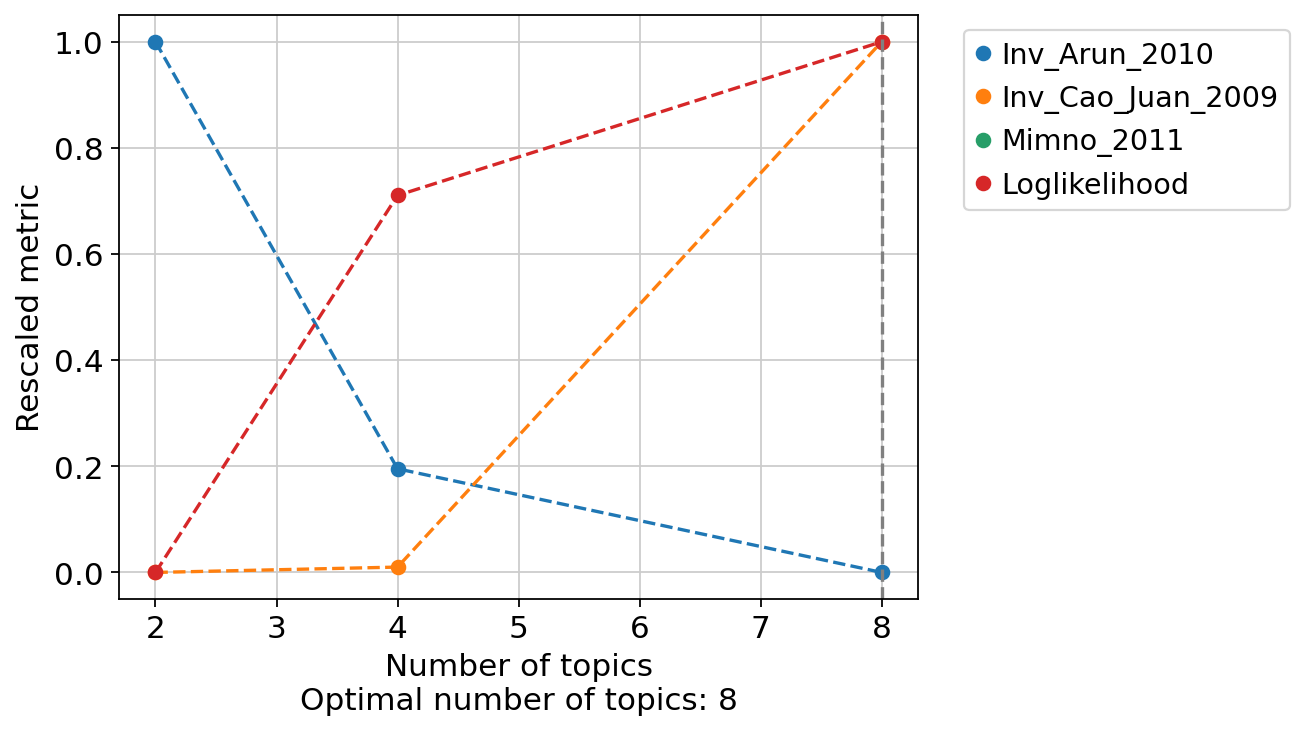

In [23]:
from pycisTopic.lda_models import *
model = evaluate_models(models,
                       select_model=8,
                       return_model=True,
                       metrics=['Arun_2010','Cao_Juan_2009', 'Minmo_2011', 'loglikelihood'],
                       plot_metrics=False)

Now we can run cisTopic to identify...

2023-01-16 09:21:42,129 cisTopic     INFO     Running UMAP


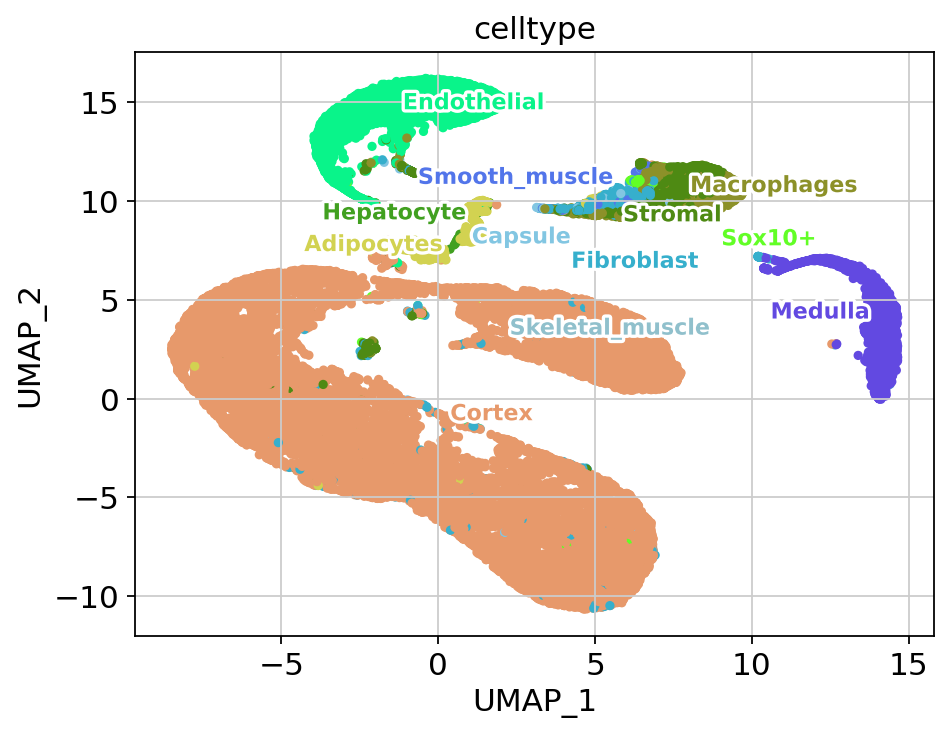

In [24]:
from pycisTopic.clust_vis import *
run_umap(cistopic_obj, target  = 'cell', scale=True)
plot_metadata(cistopic_obj, reduction_name = 'UMAP', variables = ['celltype'])

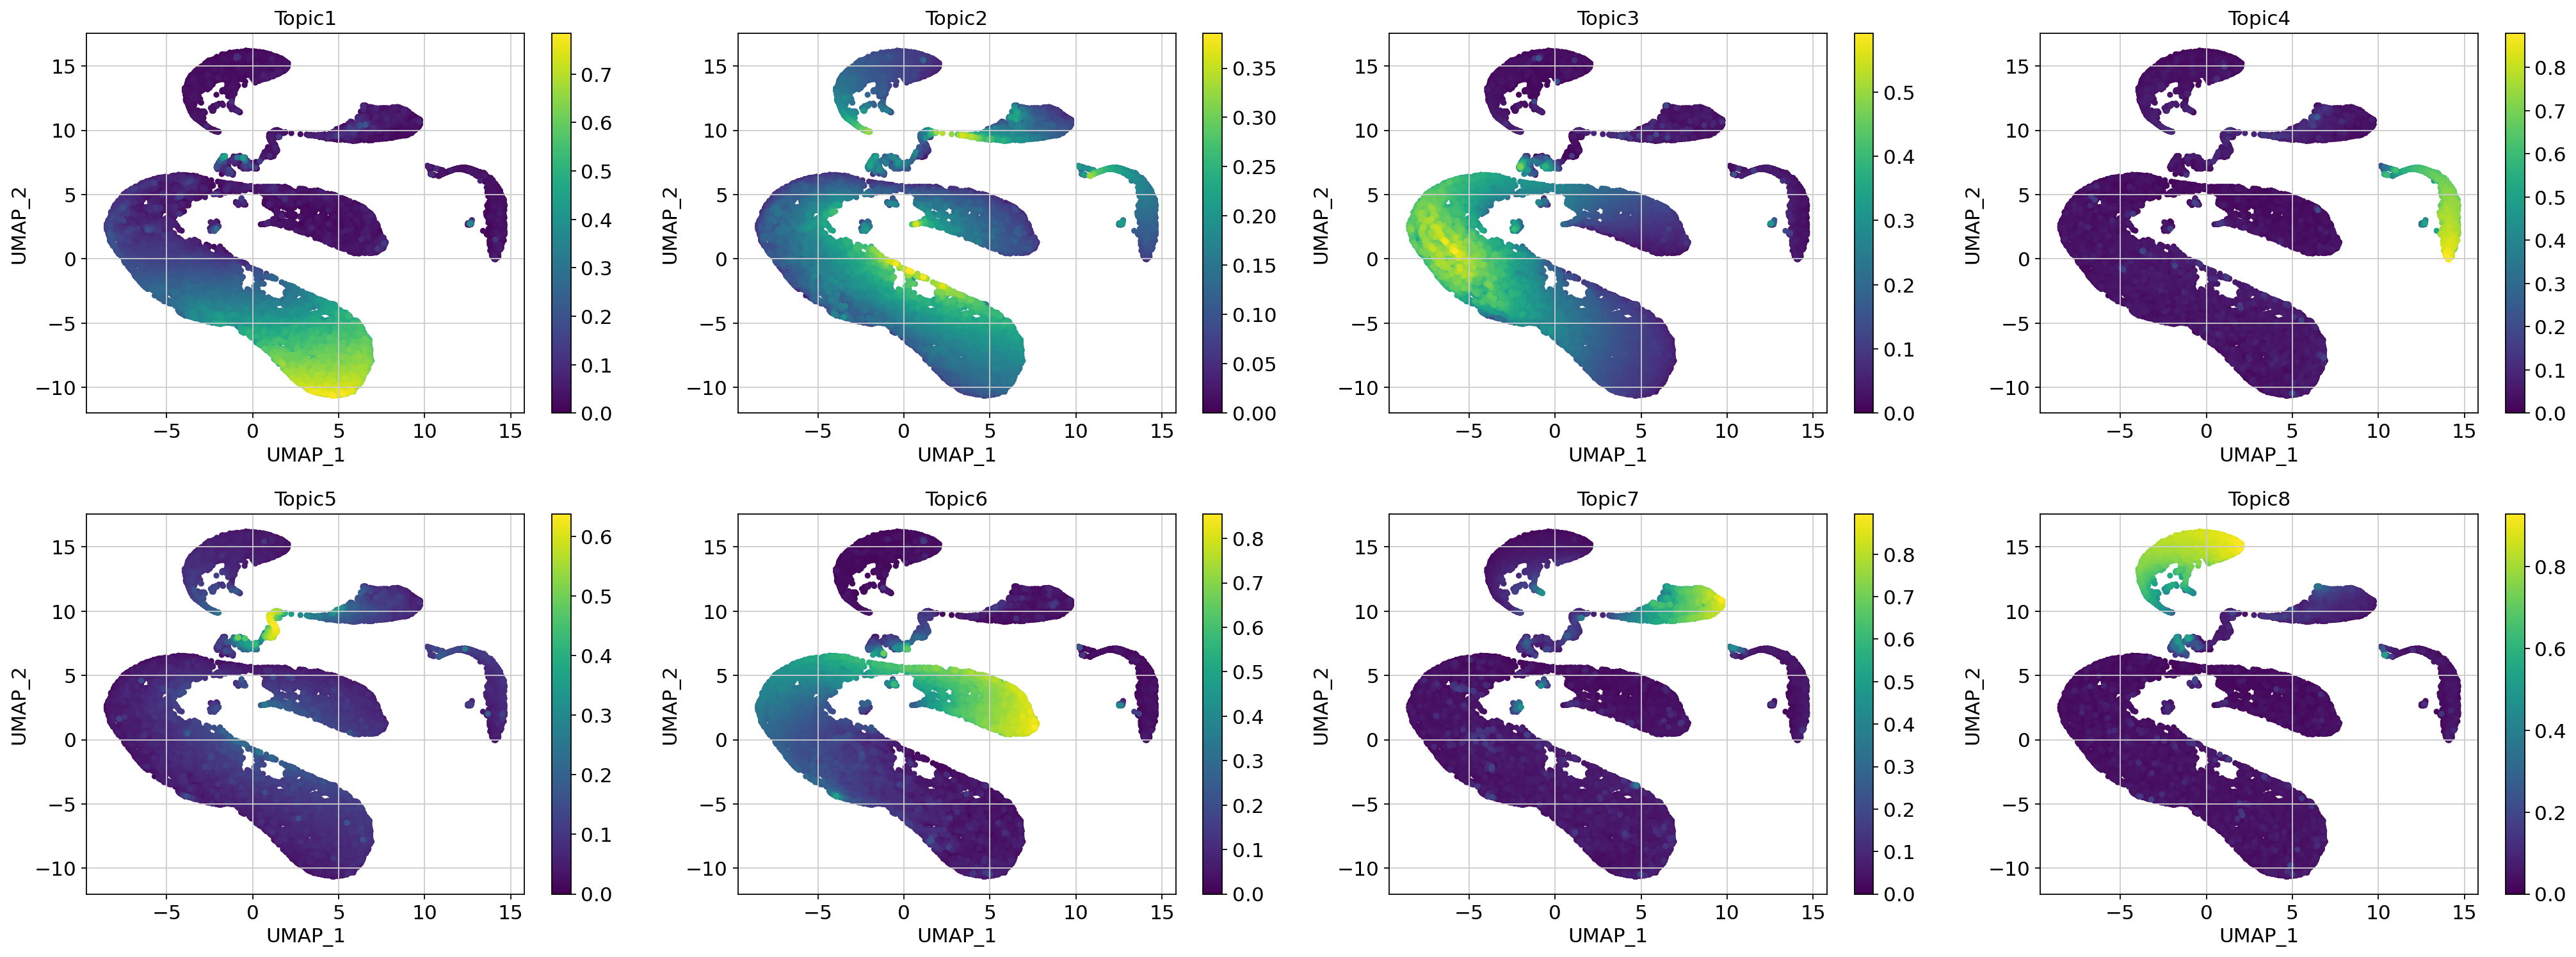

In [25]:
plot_topic(cistopic_obj, reduction_name = 'UMAP', num_columns = 4)

In [4]:
import os
import pickle

In [5]:
work_dir = "mouse_adrenal"

In [6]:
cistopic_obj = pickle.load(open(os.path.join(work_dir, 'scATAC/cistopic_obj.pkl'), 'rb'))

In [7]:
from pycisTopic.topic_binarization import *
region_bin_topics_otsu = binarize_topics(cistopic_obj, method='otsu')
region_bin_topics_top3k = binarize_topics(cistopic_obj, method='ntop', ntop = 3000)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [8]:
if not os.path.exists(os.path.join(work_dir, 'scATAC/candidate_enhancers')):
    os.makedirs(os.path.join(work_dir, 'scATAC/candidate_enhancers'))
import pickle
pickle.dump(region_bin_topics_otsu, open(os.path.join(work_dir, 'scATAC/candidate_enhancers/region_bin_topics_otsu.pkl'), 'wb'))
pickle.dump(region_bin_topics_top3k, open(os.path.join(work_dir, 'scATAC/candidate_enhancers/region_bin_topics_top3k.pkl'), 'wb'))

In [ ]:
from pycisTopic.diff_features import *
imputed_acc_obj = impute_accessibility(cistopic_obj, selected_cells=None, selected_regions=None, scale_factor=10**6)
normalized_imputed_acc_obj = normalize_scores(imputed_acc_obj, scale_factor=10**4)
variable_regions = find_highly_variable_features(normalized_imputed_acc_obj, plot = False)
markers_dict = find_diff_features(cistopic_obj, imputed_acc_obj, variable='celltype', var_features=variable_regions, split_pattern = '-')

2023-01-15 17:04:03,051 cisTopic     INFO     Imputing drop-outs
2023-01-15 17:05:09,028 cisTopic     INFO     Scaling
2023-01-15 17:06:24,540 cisTopic     INFO     Keep non zero rows
2023-01-15 17:07:55,954 cisTopic     INFO     Imputed accessibility sparsity: 0.6791389147778321
2023-01-15 17:07:55,956 cisTopic     INFO     Create CistopicImputedFeatures object
2023-01-15 17:07:55,957 cisTopic     INFO     Making matrix sparse


In [ ]:
pickle.dump(markers_dict, open(os.path.join(work_dir, 'scATAC/candidate_enhancers/markers_dict.pkl'), 'wb'))

# Scratch

## 3. scATAC-seq analysis

In [ ]:
test_fragments_dict = {"ENCFF187VMN": fragments_dict["ENCFF187VMN"]}
test_cell_data = cell_data[cell_data["sample_id"] == "ENCFF187VMN"]
test_cell_data["barcode"] = test_cell_data["atac_bc"]
test_cell_data = test_cell_data.set_index("atac_bc")
test_fragments = pd.read_csv(test_fragments_dict["ENCFF187VMN"], sep="\t", header=None)
test_cell_data["barcode"].isin(test_fragments[3]).sum()

In [ ]:
import gc
import logging
import os
import re
import subprocess
import sys
from typing import Dict, List, Optional, Union
import numpy as np
import pandas as pd
import pyBigWig
import pyranges as pr

def export_pseudobulk_one_sample(
    cell_data: pd.DataFrame,
    group: str,
    fragments_df_dict: Dict[str, pd.DataFrame],
    chromsizes: pr.PyRanges,
    bigwig_path: str,
    bed_path: str,
    sample_id_col: Optional[str] = "sample_id",
    normalize_bigwig: Optional[bool] = True,
    remove_duplicates: Optional[bool] = True,
    split_pattern: Optional[str] = "___",
):
    """
    Create pseudobulk as bed and bigwig from single cell fragments file given a barcode annotation and a group.
    Parameters
    ---------
    cell_data: pd.DataFrame
            A cell metadata :class:`pd.Dataframe` containing barcodes, their annotation and their sample of origin.
    group: str
            A character string indicating the group for which pseudobulks will be created.
    fragments_df_dict: dict
            A dictionary containing data frames as values with 'Chromosome', 'Start', 'End', 'Name', and 'Score' as columns; and sample label
            as keys. 'Score' indicates the number of times that a fragments is found assigned to that barcode.
    chromsizes: pr.PyRanges
            A :class:`pr.PyRanges` containing size of each column, containing 'Chromosome', 'Start' and 'End' columns.
    bigwig_path: str
            Path to folder where the bigwig file will be saved.
    bed_path: str
            Path to folder where the fragments bed file will be saved.
    sample_id_col: str, optional
            Name of the column containing the sample name per barcode in the input :class:`CistopicObject.cell_data` or class:`pd.DataFrame`. Default: 'sample_id'.
    normalize_bigwig: bool, optional
            Whether bigwig files should be CPM normalized. Default: True.
    remove_duplicates: bool, optional
            Whether duplicates should be removed before converting the data to bigwig.
    split_pattern: str
            Pattern to split cell barcode from sample id. Default: ___ .
    """
    # Create logger
    level = logging.INFO
    log_format = "%(asctime)s %(name)-12s %(levelname)-8s %(message)s"
    handlers = [logging.StreamHandler(stream=sys.stdout)]
    logging.basicConfig(level=level, format=log_format, handlers=handlers)
    log = logging.getLogger("cisTopic")

    log.info("Creating pseudobulk for " + str(group))
    group_fragments_list = []
    group_fragments_dict = {}
    for sample_id in fragments_df_dict:
        sample_data = cell_data[cell_data.loc[:, sample_id_col].isin([sample_id])]
        if "barcode" in sample_data:
            sample_data.index = sample_data["barcode"].tolist()
        else:
            sample_data.index = prepare_tag_cells(
                sample_data.index.tolist(), split_pattern
            )
        group_var = sample_data.iloc[:, 0]
        barcodes = group_var[group_var.isin([group])].index.tolist()
        print(barcodes)
        fragments_df = fragments_df_dict[sample_id]
        group_fragments = fragments_df.loc[fragments_df["Name"].isin(barcodes)]
        if len(fragments_df_dict) > 1:
            group_fragments_dict[sample_id] = group_fragments

    if len(fragments_df_dict) > 1:
        group_fragments_list = [
            group_fragments_dict[list(group_fragments_dict.keys())[x]]
            for x in range(len(fragments_df_dict))
        ]
        group_fragments = group_fragments_list[0].append(group_fragments_list[1:])

    del group_fragments_dict
    del group_fragments_list
    del fragments_df
    gc.collect()

    group_pr = pr.PyRanges(group_fragments)
    if isinstance(bigwig_path, str):
        bigwig_path_group = os.path.join(bigwig_path, str(group) + ".bw")
        if remove_duplicates:
            group_pr.to_bigwig(
                path=bigwig_path_group,
                chromosome_sizes=chromsizes,
                rpm=normalize_bigwig,
            )
        else:
            group_pr.to_bigwig(
                path=bigwig_path_group,
                chromosome_sizes=chromsizes,
                rpm=normalize_bigwig,
                value_col="Score",
            )
    if isinstance(bed_path, str):
        print("here")
        print(group_pr)
        bed_path_group = os.path.join(bed_path, str(group) + ".bed.gz")
        group_pr.to_bed(
            path=bed_path_group, keep=False, compression="infer", chain=False
        )

    log.info(str(group) + " done!")

In [ ]:
from pycisTopic.cistopic_class import *
from pycisTopic.pseudobulk_peak_calling import export_pseudobulk_ray
from pycisTopic.utils import read_fragments_from_file, prepare_tag_cells
def export_pseudobulk(
    input_data: Union["CistopicObject", pd.DataFrame, Dict[str, pd.DataFrame]],
    variable: str,
    chromsizes: Union[pd.DataFrame, pr.PyRanges],
    bed_path: str,
    bigwig_path: str,
    path_to_fragments: Optional[Dict[str, str]] = None,
    sample_id_col: Optional[str] = "sample_id",
    n_cpu: Optional[int] = 1,
    normalize_bigwig: Optional[bool] = True,
    remove_duplicates: Optional[bool] = True,
    split_pattern: Optional[str] = "___",
    use_polars: Optional[bool] = True,
    **kwargs
):
    """
    Create pseudobulks as bed and bigwig from single cell fragments file given a barcode annotation.
    Parameters
    ---------
    input_data: CistopicObject or pd.DataFrame
            A :class:`CistopicObject` containing the specified `variable` as a column in :class:`CistopicObject.cell_data` or a cell metadata
            :class:`pd.DataFrame` containing barcode as rows, containing the specified `variable` as a column (additional columns are
            possible) and a `sample_id` column. Index names must contain the BARCODE (e.g. ATGTCGTC-1), additional tags are possible separating with -
            (e.g. ATGCTGTGCG-1-Sample_1). The levels in the sample_id column must agree with the keys in the path_to_fragments dictionary.
            Alternatively, if the cell metadata contains a column named barcode it will be used instead of the index names.
    variable: str
            A character string indicating the column that will be used to create the different group pseudobulk. It must be included in
            the cell metadata provided as input_data.
    chromsizes: pd.DataFrame or pr.PyRanges
            A data frame or :class:`pr.PyRanges` containing size of each chromosome, containing 'Chromosome', 'Start' and 'End' columns.
    bed_path: str
            Path to folder where the fragments bed files per group will be saved. If None, files will not be generated.
    bigwig_path: str
            Path to folder where the bigwig files per group will be saved. If None, files will not be generated.
    path_to_fragments: str or dict, optional
            A dictionary of character strings, with sample name as names indicating the path to the fragments file/s from which pseudobulk profiles have to
            be created. If a :class:`CistopicObject` is provided as input it will be ignored, but if a cell metadata :class:`pd.DataFrame` is provided it
            is necessary to provide it. The keys of the dictionary need to match with the sample_id tag added to the index names of the input data frame.
    sample_id_col: str, optional
            Name of the column containing the sample name per barcode in the input :class:`CistopicObject.cell_data` or class:`pd.DataFrame`. Default: 'sample_id'.
    n_cpu: int, optional
            Number of cores to use. Default: 1.
    normalize_bigwig: bool, optional
            Whether bigwig files should be CPM normalized. Default: True.
    remove_duplicates: bool, optional
            Whether duplicates should be removed before converting the data to bigwig.
    split_pattern: str, optional
            Pattern to split cell barcode from sample id. Default: ___ .
    use_polars: bool, optional
            Whether to use polars to read fragments files. Default: True.
    **kwargs
            Additional parameters for ray.init()
    Return
    ------
    dict
            A dictionary containing the paths to the newly created bed fragments files per group a dictionary containing the paths to the
            newly created bigwig files per group.
    """
    # Create logger
    level = logging.INFO
    log_format = "%(asctime)s %(name)-12s %(levelname)-8s %(message)s"
    handlers = [logging.StreamHandler(stream=sys.stdout)]
    logging.basicConfig(level=level, format=log_format, handlers=handlers)
    log = logging.getLogger("cisTopic")

    # Get fragments file
    if isinstance(input_data, CistopicObject):
        path_to_fragments = input_data.path_to_fragments
        if path_to_fragments is None:
            log.error("No path_to_fragments in this cisTopic object.")
        cell_data = input_data.cell_data
    elif isinstance(input_data, pd.DataFrame):
        if path_to_fragments is None:
            log.error("Please, provide path_to_fragments.")
        cell_data = input_data
    # Check for sample_id column
    try:
        sample_ids = list(set(cell_data[sample_id_col]))
    except ValueError:
        print(
            'Please, include a sample identification column (e.g. "sample_id") in your cell metadata!'
        )

    # Get fragments
    #fragments_df_dict = {}
    """
    for sample_id in path_to_fragments.keys():
        if sample_id not in sample_ids:
            log.info(
                "The following path_to_fragments entry is not found in the cell metadata sample_id_col: ",
                sample_id,
                ". It will be ignored.",
            )
        else:
            log.info("Reading fragments from " + path_to_fragments[sample_id])
            fragments_df = read_fragments_from_file(path_to_fragments[sample_id], use_polars=use_polars).df
            # Convert to int32 for memory efficiency
            fragments_df.Start = np.int32(fragments_df.Start)
            fragments_df.End = np.int32(fragments_df.End)
            if "Score" in fragments_df:
                fragments_df.Score = np.int32(fragments_df.Score)
            if "barcode" in cell_data:
                fragments_df = fragments_df.loc[
                    fragments_df["Name"].isin(cell_data["barcode"].tolist())
                ]
            else:
                fragments_df = fragments_df.loc[
                    fragments_df["Name"].isin(
                        prepare_tag_cells(cell_data.index.tolist(), split_pattern)
                    )
                ]
            fragments_df_dict[sample_id] = fragments_df
    """
    
    # Set groups
    if "barcode" in cell_data:
        cell_data = cell_data.loc[:, [variable, sample_id_col, "barcode"]]
    else:
        cell_data = cell_data.loc[:, [variable, sample_id_col]]
    cell_data[variable] = cell_data[variable].replace(" ", "", regex=True)
    cell_data[variable] = cell_data[variable].replace("[^A-Za-z0-9]+", "_", regex=True)
    groups = sorted(list(set(cell_data[variable])))
    groups = groups[:2]
    print(groups)
    # Check chromosome sizes
    if isinstance(chromsizes, pd.DataFrame):
        chromsizes = chromsizes.loc[:, ["Chromosome", "Start", "End"]]
        chromsizes = pr.PyRanges(chromsizes)
    # Check that output dir exist and generate output paths
    if isinstance(bed_path, str):
        if not os.path.exists(bed_path):
            os.makedirs(bed_path)
        bed_paths = {
            group: os.path.join(bed_path, str(group) + ".bed.gz") for group in groups
        }
    else:
        bed_paths = {}
    if isinstance(bigwig_path, str):
        if not os.path.exists(bigwig_path):
            os.makedirs(bigwig_path)
        bw_paths = {
            group: os.path.join(bigwig_path, str(group) + ".bw") for group in groups
        }
    else:
        bw_paths = {}
    # Create pseudobulks
    print(cell_data)
    print(groups)
    print(fragments_df_dict)
    print(chromsizes)
    print(bigwig_path, bed_path)
    print(sample_id_col)
    if n_cpu > 1:
        ray.init(num_cpus=n_cpu, **kwargs)
        ray_handle = ray.wait(
            [
                export_pseudobulk_ray.remote(
                    cell_data,
                    group,
                    fragments_df_dict,
                    chromsizes,
                    bigwig_path,
                    bed_path,
                    sample_id_col,
                    normalize_bigwig,
                    remove_duplicates,
                    split_pattern,
                )
                for group in groups
            ],
            num_returns=len(groups),
        )
        ray.shutdown()
    else:
        [
            export_pseudobulk_one_sample(
                cell_data,
                group,
                fragments_df_dict,
                chromsizes,
                bigwig_path,
                bed_path,
                sample_id_col,
                normalize_bigwig,
                remove_duplicates,
                split_pattern,
            )
            for group in groups
        ]

    return bw_paths, bed_paths

In [ ]:
bw_paths, bed_paths = export_pseudobulk(
    input_data = test_cell_data,
    variable = 'celltypes', # variable by which to generate pseubulk profiles, in this case we want pseudobulks per celltype
    sample_id_col = 'sample_id',
    chromsizes = chromsizes,
    bed_path = os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bed_files/'),  # specify where pseudobulk_bed_files should be stored
    bigwig_path = os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bw_files/'), # specify where pseudobulk_bw_files should be stored
    path_to_fragments = test_fragments_dict, # location of fragment fiels
    n_cpu = 1, # specify the number of cores to use, we use ray for multi processing
    normalize_bigwig = True,
    remove_duplicates = True,
    _temp_dir = os.path.join(tmp_dir, 'ray_spill'),
    split_pattern = '-'
)

In [ ]:
from pycisTopic.pseudobulk_peak_calling import export_pseudobulk
bw_paths, bed_paths = export_pseudobulk(
    input_data = cell_data,
    variable = 'celltype', # variable by which to generate pseubulk profiles, in this case we want pseudobulks per celltype
    sample_id_col = 'sample_id',
    chromsizes = chromsizes,
    bed_path = os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bed_files/'),  # specify where pseudobulk_bed_files should be stored
    bigwig_path = os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bw_files/'), # specify where pseudobulk_bw_files should be stored
    path_to_fragments = fragments_dict, # location of fragment fiels
    n_cpu = 12, # specify the number of cores to use, we use ray for multi processing
    normalize_bigwig = True,
    remove_duplicates = True,
    _temp_dir = os.path.join(tmp_dir, 'ray_spill'),
    split_pattern = '-'
)

In [ ]:
import logging

In [ ]:
path_to_fragments = test_fragments_dict
sample_id_col = "sample_id"
variable = "celltypes"
sample_ids = list(set(cell_data[sample_id_col]))
use_polars = True
level = logging.INFO
log_format = "%(asctime)s %(name)-12s %(levelname)-8s %(message)s"
handlers = [logging.StreamHandler(stream=sys.stdout)]
logging.basicConfig(level=level, format=log_format, handlers=handlers)
log = logging.getLogger("cisTopic")
cell_data = test_cell_data
bed_path = os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bed_files/')
bigwig_path = os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bw_files/'),

In [ ]:
from pycisTopic.utils import read_fragments_from_file, prepare_tag_cells

In [ ]:
import numpy as np

In [ ]:
fragments_df_dict = {}
for sample_id in path_to_fragments.keys():
    if sample_id not in sample_ids:
        log.info(
            "The following path_to_fragments entry is not found in the cell metadata sample_id_col: ",
            sample_id,
            ". It will be ignored.",
        )
    else:
        log.info("Reading fragments from " + path_to_fragments[sample_id])

        fragments_df = read_fragments_from_file(path_to_fragments[sample_id], use_polars=use_polars).df
        # Convert to int32 for memory efficiency
        fragments_df.Start = np.int32(fragments_df.Start)
        fragments_df.End = np.int32(fragments_df.End)
        if "Score" in fragments_df:
            fragments_df.Score = np.int32(fragments_df.Score)
        if "barcode" in cell_data:
            fragments_df = fragments_df.loc[
                fragments_df["Name"].isin(cell_data["barcode"].tolist())
            ]
        else:
            fragments_df = fragments_df.loc[
                fragments_df["Name"].isin(
                    prepare_tag_cells(cell_data.index.tolist(), split_pattern)
                )
            ]
        fragments_df_dict[sample_id] = fragments_df

In [ ]:
if "barcode" in cell_data:
    cell_data = cell_data.loc[:, [variable, sample_id_col, "barcode"]]
else:
    cell_data = cell_data.loc[:, [variable, sample_id_col]]
cell_data[variable] = cell_data[variable].replace(" ", "", regex=True)
cell_data[variable] = cell_data[variable].replace("[^A-Za-z0-9]+", "_", regex=True)
groups = sorted(list(set(cell_data[variable])))

In [ ]:
cell_data

In [ ]:
group = groups[0]

In [ ]:
level = logging.INFO
log_format = "%(asctime)s %(name)-12s %(levelname)-8s %(message)s"
handlers = [logging.StreamHandler(stream=sys.stdout)]
logging.basicConfig(level=level, format=log_format, handlers=handlers)
log = logging.getLogger("cisTopic")

log.info("Creating pseudobulk for " + str(group))
group_fragments_list = []
group_fragments_dict = {}

In [ ]:
log.info("Creating pseudobulk for " + str(group))
group_fragments_list = []
group_fragments_dict = {}
for sample_id in fragments_df_dict:
    print(sample_id)
    sample_data = cell_data[cell_data.loc[:, sample_id_col].isin([sample_id])]
    if "barcode" in sample_data:
        sample_data.index = sample_data["barcode"].tolist()
    else:
        sample_data.index = prepare_tag_cells(
            sample_data.index.tolist(), split_pattern
        )
    group_var = sample_data.iloc[:, 0]
    barcodes = group_var[group_var.isin([group])].index.tolist()
    fragments_df = fragments_df_dict[sample_id]
    group_fragments = fragments_df.loc[fragments_df["Name"].isin(barcodes)]
    if len(fragments_df_dict) > 1:
        group_fragments_dict[sample_id] = group_fragments

In [ ]:
sample_data

In [ ]:
sample_data = cell_data[cell_data.loc[:, sample_id_col].isin([sample_id])]

In [ ]:
if len(fragments_df_dict) > 1:
        group_fragments_list = [
            group_fragments_dict[list(group_fragments_dict.keys())[x]]
            for x in range(len(fragments_df_dict))
        ]
        group_fragments = group_fragments_list[0].append(group_fragments_list[1:])

In [ ]:
del group_fragments_dict
del group_fragments_list
del fragments_df
gc.collect()

group_pr = pr.PyRanges(group_fragments)

In [ ]:
group_pr

In [ ]:
if isinstance(bigwig_path, str):
    bigwig_path_group = os.path.join(bigwig_path, str(group) + ".bw")
    if remove_duplicates:
        group_pr.to_bigwig(
            path=bigwig_path_group,
            chromosome_sizes=chromsizes,
            rpm=normalize_bigwig,
        )
    else:
        group_pr.to_bigwig(
            path=bigwig_path_group,
            chromosome_sizes=chromsizes,
            rpm=normalize_bigwig,
            value_col="Score",
        )
if isinstance(bed_path, str):
    print("here")
    print(group_pr)
    bed_path_group = os.path.join(bed_path, str(group) + ".bed.gz")
    group_pr.to_bed(
        path=bed_path_group, keep=False, compression="infer", chain=False
    )

log.info(str(group) + " done!")

In [ ]:
import gc
import logging
import os
import re
import subprocess
import sys
from typing import Dict, List, Optional, Union
import numpy as np
import pandas as pd
import pyBigWig
import pyranges as pr

def export_pseudobulk_one_sample(
    cell_data: pd.DataFrame,
    group: str,
    fragments_df_dict: Dict[str, pd.DataFrame],
    chromsizes: pr.PyRanges,
    bigwig_path: str,
    bed_path: str,
    sample_id_col: Optional[str] = "sample_id",
    normalize_bigwig: Optional[bool] = True,
    remove_duplicates: Optional[bool] = True,
    split_pattern: Optional[str] = "___",
):
    """
    Create pseudobulk as bed and bigwig from single cell fragments file given a barcode annotation and a group.
    Parameters
    ---------
    cell_data: pd.DataFrame
            A cell metadata :class:`pd.Dataframe` containing barcodes, their annotation and their sample of origin.
    group: str
            A character string indicating the group for which pseudobulks will be created.
    fragments_df_dict: dict
            A dictionary containing data frames as values with 'Chromosome', 'Start', 'End', 'Name', and 'Score' as columns; and sample label
            as keys. 'Score' indicates the number of times that a fragments is found assigned to that barcode.
    chromsizes: pr.PyRanges
            A :class:`pr.PyRanges` containing size of each column, containing 'Chromosome', 'Start' and 'End' columns.
    bigwig_path: str
            Path to folder where the bigwig file will be saved.
    bed_path: str
            Path to folder where the fragments bed file will be saved.
    sample_id_col: str, optional
            Name of the column containing the sample name per barcode in the input :class:`CistopicObject.cell_data` or class:`pd.DataFrame`. Default: 'sample_id'.
    normalize_bigwig: bool, optional
            Whether bigwig files should be CPM normalized. Default: True.
    remove_duplicates: bool, optional
            Whether duplicates should be removed before converting the data to bigwig.
    split_pattern: str
            Pattern to split cell barcode from sample id. Default: ___ .
    """
    # Create logger
    level = logging.INFO
    log_format = "%(asctime)s %(name)-12s %(levelname)-8s %(message)s"
    handlers = [logging.StreamHandler(stream=sys.stdout)]
    logging.basicConfig(level=level, format=log_format, handlers=handlers)
    log = logging.getLogger("cisTopic")

    log.info("Creating pseudobulk for " + str(group))
    group_fragments_list = []
    group_fragments_dict = {}
    for sample_id in fragments_df_dict:
        sample_data = cell_data[cell_data.loc[:, sample_id_col].isin([sample_id])]
        if "barcode" in sample_data:
            sample_data.index = sample_data["barcode"].tolist()
        else:
            sample_data.index = prepare_tag_cells(
                sample_data.index.tolist(), split_pattern
            )
        group_var = sample_data.iloc[:, 0]
        barcodes = group_var[group_var.isin([group])].index.tolist()
        fragments_df = fragments_df_dict[sample_id]
        group_fragments = fragments_df.loc[fragments_df["Name"].isin(barcodes)]
        if len(fragments_df_dict) > 1:
            group_fragments_dict[sample_id] = group_fragments

    if len(fragments_df_dict) > 1:
        group_fragments_list = [
            group_fragments_dict[list(group_fragments_dict.keys())[x]]
            for x in range(len(fragments_df_dict))
        ]
        group_fragments = group_fragments_list[0].append(group_fragments_list[1:])

    del group_fragments_dict
    del group_fragments_list
    del fragments_df
    gc.collect()

    group_pr = pr.PyRanges(group_fragments)
    if isinstance(bigwig_path, str):
        bigwig_path_group = os.path.join(bigwig_path, str(group) + ".bw")
        if remove_duplicates:
            group_pr.to_bigwig(
                path=bigwig_path_group,
                chromosome_sizes=chromsizes,
                rpm=normalize_bigwig,
            )
        else:
            group_pr.to_bigwig(
                path=bigwig_path_group,
                chromosome_sizes=chromsizes,
                rpm=normalize_bigwig,
                value_col="Score",
            )
    if isinstance(bed_path, str):
        print("here")
        print(group_pr)
        bed_path_group = os.path.join(bed_path, str(group) + ".bed.gz")
        group_pr.to_bed(
            path=bed_path_group, keep=False, compression="infer", chain=False
        )

    log.info(str(group) + " done!")

In [ ]:
sample_data

In [ ]:
fragments_df_dict["ENCFF187VMN"]

In [ ]:
export_pseudobulk_one_sample(
    cell_data,
    groups[2],
    fragments_df_dict,
    chromsizes,
    bigwig_path,
    bed_path,
    sample_id_col,
    True,
    True,
    "-"
)

In [ ]:
test = [
export_pseudobulk_one_sample(
    cell_data,
    group,
    fragments_df_dict,
    chromsizes,
    bigwig_path,
    bed_path,
    sample_id_col,
    True,
    True,
    "-",
)
for group in groups
]

In [ ]:
from pycisTopic.pseudobulk_peak_calling import export_pseudobulk
bw_paths, bed_paths = export_pseudobulk(
    input_data = test_cell_data,
    variable = 'celltypes', # variable by which to generate pseubulk profiles, in this case we want pseudobulks per celltype
    sample_id_col = 'sample_id',
    chromsizes = chromsizes,
    bed_path = os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bed_files/'),  # specify where pseudobulk_bed_files should be stored
    bigwig_path = os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bw_files/'), # specify where pseudobulk_bw_files should be stored
    path_to_fragments = test_fragments_dict, # location of fragment fiels
    n_cpu = 1, # specify the number of cores to use, we use ray for multi processing
    normalize_bigwig = True,
    remove_duplicates = True,
    _temp_dir = os.path.join(tmp_dir, 'ray_spill'),
    split_pattern = '-'
)